# Zonal Mean Analysis
This notebook applies the adiabatic theory for convectively set change in temperature to a range of latitudes.

It is adapted from the [theory breakdown.ipynb](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/land/meridional_band/publish_figures/theory_breakdown.ipynb) notebook used for Isca simulations.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms,mse_mod_anom_change_ft_expansion, mse_mod_change_surf_expansion, \
    get_scaling_factor_theory, get_temp_adiabat, get_p_x, decompose_temp_ft_anom_change
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [157]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

#### Load in Data
Quantile data is obtained from CESM datasets and output into npz files. Here I am just interested in the npz files. For quantile data, the shape of array is `[2, n_lat, n_quant]` where the first index is `0` for land and `1` for ocean coordinates (quantiles are found separately at each latitude for land and ocean).

In [522]:
dir_npz = '/Users/joshduffield/Documents/StAndrews/Isca/cesm/output_npz'
exp_names = ['e.e20.E1850TEST.f09_g17.daily_output', 'e.e20.E1850TEST.f09_g17.co2_4x_daily_output']
# exp_names = ['isca/tau_sweep.land.meridional_band.depth=1.bucket_evap.k=1', 'isca/tau_sweep.land.meridional_band.depth=1.bucket_evap.k=2']
n_exp = len(exp_names)
ds_base = [np.load(os.path.join(dir_npz, exp_names[i]+'.lat_quant_info.npz')) for i in range(n_exp)]

if not np.all(ds_base[0]['quant']==ds_base[1]['quant']):
    raise ValueError('Quantiles change between datasets')

if not np.all(ds_base[0]['lat']==ds_base[1]['lat']):
    raise ValueError('Latitudes change between datasets')

if not np.all(ds_base[0]['surface']==ds_base[1]['surface']):
    raise ValueError('Surface change between datasets')

In [523]:
# Create one dataset with all experiments with shape [n_surf, n_quant, n_exp, n_lat]
lat = ds_base[0]['lat']
n_surf = ds_base[0]['surface'].size
n_lat = lat.size
n_quant = ds_base[0]['quant'].size
ds = {}     
for i in range(n_exp):
    for j in range(n_surf):
        no_surf_ind = np.where(ds_base[i]['n_grid_points'][j]==0)[0]
        for key in ds_base[i]:
            if ds_base[i][key].shape != (n_surf, n_lat, n_quant) or ds_base[i][key].dtype=='int':
                continue
            if key not in ds:
                ds[key] = np.zeros((n_surf, n_quant, n_exp, n_lat))
            ds[key][j, :, i] = ds_base[i][key][j].T
            ds[key][j, :, i, no_surf_ind] = np.nan      # Set to nan all latitudes where there is no coordinate of given surface

In [524]:
lat_ref_approx = 0.4
ind_lat_ref = np.argmin(np.abs(lat-lat_ref_approx))
lat_ref = lat[ind_lat_ref]
if 'pressure_surf_approx' in ds_base[0]:
    pressure_surf = float(ds_base[0]['pressure_surf_approx'])
    pressure_ft = float(ds_base[0]['pressure_ft_approx'])
else:
    pressure_surf = float(ds_base[0]['pressure_surf'])
    pressure_ft = float(ds_base[0]['pressure_ft'])

## Theory
Below I plot how well various versions of the theory do.

In [562]:
sf_simulated = (ds['temp'][:, :, 1] - ds['temp'][:, :, 0]) / (ds['temp'][:, :, 1] - ds['temp'][:, :, 0])[:, :,  ind_lat_ref, np.newaxis]
sf_simulated_error = np.sqrt((ds['temp_std'][:, :, 0]/(ds['temp'][:, :, 1] - ds['temp'][:, :, 0])[:, :,  ind_lat_ref:ind_lat_ref+1])**2 +
                             (ds['temp_std'][:, :, 1]/(ds['temp'][:, :, 1] - ds['temp'][:, :, 0])[:, :,  ind_lat_ref:ind_lat_ref+1])**2)
sf_theory = {key: np.zeros((n_surf, n_quant, n_lat)) for key in ['linear', 'non_linear', 'simple', 'sce_linear', 'sce_non_linear', 'sce_simple']}
keys_sf_breakdown = {var+'_mean_change': ['t0', 't0_r0', 'r0', 'e0'] for var in ['t', 'r', 'e']}
keys_sf_breakdown['anomaly_change'] = ['r', 't0_r', 'ft', 'e']
gamma_ft = np.zeros((n_surf, n_quant))
sf_theory_breakdown = {key1: {key2: np.zeros((n_surf, n_quant, n_lat)) for key2 in keys_sf_breakdown[key1]} for key1 in keys_sf_breakdown}
for i in range(n_surf):
    for j in range(n_quant):
        for key in sf_theory:
            sf_theory[key][i, j], info_coef, _, info_cont, _ = \
                get_scaling_factor_theory(ds['temp'][i, j, :,  ind_lat_ref], ds['temp'][i, j], ds['sphum'][i, j, :,  ind_lat_ref],
                                          ds['sphum'][i, j], pressure_surf, pressure_ft, 
                                          ds['temp_ft'][i, j, :,  ind_lat_ref], ds['temp_ft'][i, j], 
                                          ds['z_ft'][i, j, :,  ind_lat_ref], ds['z_ft'][i, j],
                                          non_linear='non_linear' in key, use_temp_adiabat=True, 
                                          strict_conv_eqb='sce' in key, 
                                          simple='simple' in key)
            if key == 'linear':
                # Only record breakdown for linear case as easier to interpret
                for key1 in keys_sf_breakdown:
                    for key2 in keys_sf_breakdown[key1]:
                        sf_theory_breakdown[key1][key2][i, j] = info_cont[key1][key2]
                gamma_ft[i, j] = info_coef['anomaly_change']['ft'][0]

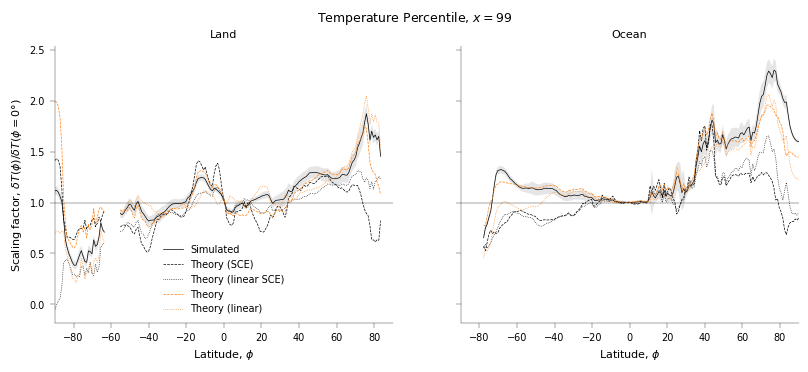

In [563]:
q_plot = 99     # decide which quantile to plot
q_plot_ind = np.where(ds_base[0]['quant']==q_plot)[0][0]

save_sf_theory_fig = False
fig, ax = plt.subplots(1,n_surf, figsize=(n_surf*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_surf):
    ax[i].plot(lat, sf_simulated[i, q_plot_ind], color='k', label='Simulated')
    ax[i].plot(lat, sf_theory['sce_non_linear'][i, q_plot_ind], color='k', linestyle='--', label='Theory (SCE)')
    ax[i].plot(lat, sf_theory['sce_simple'][i, q_plot_ind], color='k', linestyle=':', label='Theory (linear SCE)')
    ax[i].plot(lat, sf_theory['non_linear'][i, q_plot_ind], color=default_colors[1], linestyle='--', label='Theory')
    ax[i].plot(lat, sf_theory['simple'][i, q_plot_ind], color=default_colors[1], linestyle=':', label='Theory (linear)')
    ax[i].fill_between(lat, sf_simulated[i, q_plot_ind]+sf_simulated_error[i, q_plot_ind], 
                       sf_simulated[i, q_plot_ind]-sf_simulated_error[i, q_plot_ind], fc='k', alpha=0.1)
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Latitude, $\phi$')
    ax[i].set_title(ds_base[0]['surface'][i].capitalize())
ax[0].set_ylabel(f'Scaling factor, $\delta T(\phi)/\delta T(\phi={lat_ref:.0f}\degree)$')
ax[0].legend()
ax[0].set_xlim(-90, 90)
fig.suptitle(f'Temperature Percentile, $x={q_plot}$', fontsize=9)
if save_fig or save_sf_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_theory_{q_plot}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Breakdown into 4 change contributions
The theory can be split into 4 change ($\delta$) terms: 
* ${\delta \overline{T_s}$
* $\delta \overline{r_s}$
* $\delta \overline{\epsilon_s}$
* $\delta \Delta \chi(x)$ terms for $\chi = r, T_{FT}, \epsilon$

Here I plot the contribution of each of these (assuming the linear theory).

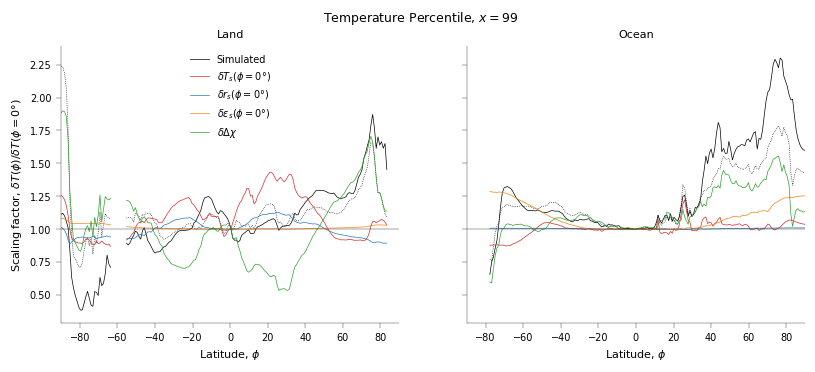

In [535]:
colors_breakdown = {'t_mean_change': default_colors[3], 'r_mean_change': default_colors[0], 'e_mean_change': default_colors[1], 
                    'anomaly_change': default_colors[2]}
labels_breakdown1 = {'t_mean_change': f'$\delta T_s(\phi={lat_ref:.0f}\degree)$', 'r_mean_change': f'$\delta r_s(\phi={lat_ref:.0f}\degree)$', 
                     'e_mean_change': f'$\delta \epsilon_s(\phi={lat_ref:.0f}\degree)$', 'anomaly_change': '$\delta \Delta \chi$'}

save_breakdown_change_fig = False
fig, ax = plt.subplots(1,n_surf, figsize=(n_surf*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_surf):
    ax[i].plot(lat, sf_simulated[i, q_plot_ind], color='k', label='Simulated')
    ax[i].plot(lat, sf_theory['linear'][i, q_plot_ind], color='k', linestyle=':')
    # ax[i].plot(lat, sf_theory['non_linear'][i, q_plot_ind], color='k', linestyle='--')
    for key1 in keys_sf_breakdown:
        ax[i].plot(lat, 1+sum([sf_theory_breakdown[key1][key2][i, q_plot_ind] for key2 in keys_sf_breakdown[key1]]),
                color=colors_breakdown[key1], label=labels_breakdown1[key1])
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Latitude, $\phi$')
    ax[i].set_title(ds_base[0]['surface'][i].capitalize())
ax[0].legend()
ax[0].set_ylabel(f'Scaling factor, $\delta T(\phi)/\delta T(\phi={lat_ref:.0f}\degree)$')
ax[0].set_xlim(-90, 90)
fig.suptitle(f'Temperature Percentile, $x={q_plot}$', fontsize=9)

if save_fig or save_breakdown_change_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_breakdown_change_{q_plot}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Plot showing the most significant terms

In [536]:
n_sig_terms = 4
info_sig_terms = [[{'key1': ['' for i in range(n_sig_terms)], 'key2': ['' for i in range(n_sig_terms)], 'max_abs': np.zeros(n_sig_terms)} 
                   for j in range(n_quant)] for k in range(n_surf)]
for i in range(n_surf):
    for j in range(n_quant):
        for key1 in keys_sf_breakdown:
            for key2 in keys_sf_breakdown[key1]:
                # if 'e' in key2:
                #     continue
                var_cont_abs_max = np.nanmax(np.abs(sf_theory_breakdown[key1][key2][i, j]))
                ind_min = info_sig_terms[i][j]['max_abs'].argmin()
                if var_cont_abs_max > info_sig_terms[i][j]['max_abs'][ind_min]:
                    info_sig_terms[i][j]['max_abs'][ind_min] = var_cont_abs_max
                    info_sig_terms[i][j]['key1'][ind_min] = key1
                    info_sig_terms[i][j]['key2'][ind_min] = key2

        ind_sort = info_sig_terms[i][j]['max_abs'].argsort()[::-1]
        for key in info_sig_terms[i][j]:
            info_sig_terms[i][j][key] = [info_sig_terms[i][j][key][k] for k in ind_sort]
        info_sig_terms[i][j]['max_abs'] = np.asarray(info_sig_terms[i][j]['max_abs'])

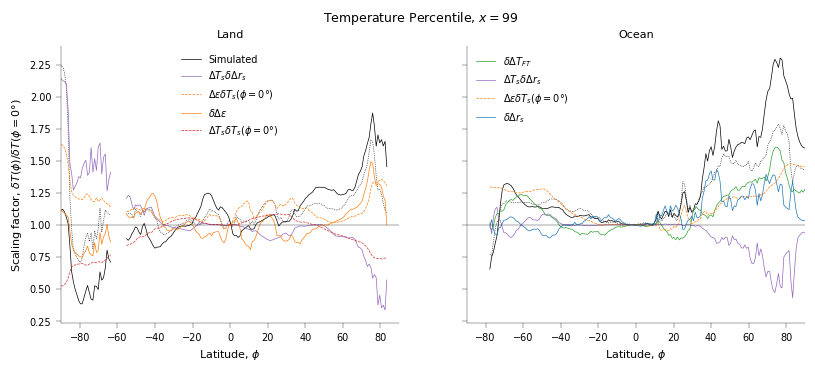

In [537]:
linestyles_breakdown = {'t_mean_change': '--', 'r_mean_change': '-.', 'e_mean_change': ':', 
                        'anomaly_change': '-'}
colors_breakdown2 = {'t0': default_colors[3], 'r0': default_colors[0], 't0_r0': default_colors[4], 'e0': default_colors[1], 
                     'e': default_colors[1], 'r': default_colors[0], 't0_r': default_colors[4], 
                     'ft': default_colors[2]}
labels_breakdown2 = {'t0': '$\Delta T_s$', 'r0': '$\Delta r_s$', 't0_r0': '$\Delta T_s \Delta r_s$', 'e0': '$\Delta \epsilon$', 
                     'e': '$\delta \Delta \epsilon$', 'r': '$\delta \Delta r_s$', 't0_r': '$\Delta T_s\delta \Delta r_s$', 
                     'ft': '$\delta \Delta T_{FT}$'}

save_sig_terms_fig = False
fig, ax = plt.subplots(1,n_surf, figsize=(n_surf*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_exp):
    ax[i].plot(lat, sf_simulated[i, q_plot_ind], color='k', label='Simulated' if i==0 else None)
    ax[i].plot(lat, sf_theory['linear'][i, q_plot_ind], color='k', linestyle=':')
    # ax[i].plot(lat, sf_theory['non_linear'][i, q_plot_ind], color='k', linestyle='--')
    for k in range(n_sig_terms):
        key1 = info_sig_terms[i][q_plot_ind]['key1'][k]
        key2 = info_sig_terms[i][q_plot_ind]['key2'][k]
        ax[i].plot(lat, 1+sf_theory_breakdown[key1][key2][i, q_plot_ind], color=colors_breakdown2[key2],
                linestyle=linestyles_breakdown[key1], label=labels_breakdown2[key2] + ('' if 'anomaly' in key1 else labels_breakdown1[key1]))
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Latitude, $\phi$')
    ax[i].set_title(ds_base[0]['surface'][i].capitalize())
    ax[i].legend()
ax[0].set_ylabel(f'Scaling factor, $\delta T(\phi)/\delta T(\phi={lat_ref:.0f}\degree)$')
ax[0].set_xlim(-90, 90)
fig.suptitle(f'Temperature Percentile, $x={q_plot}$', fontsize=9);

### Plot showing the simple linear $\delta \overline{T_s}$ terms

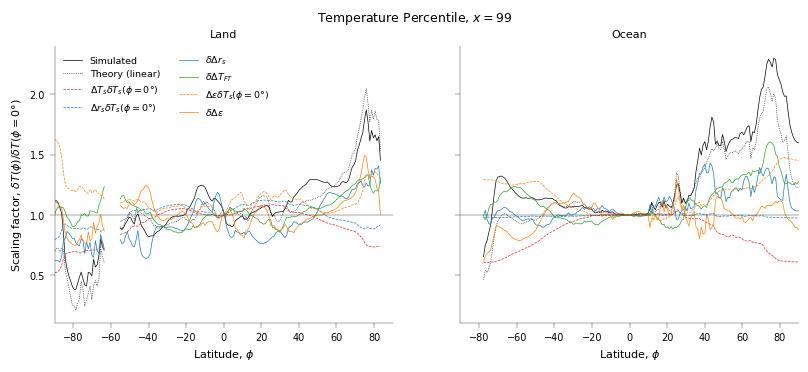

In [538]:
save_linear_terms_fig = False
fig, ax = plt.subplots(1,n_surf, figsize=(n_surf*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
# alpha_plot = 0.15
alpha_plot = 1

# Start with strict convective equilibrium theory
for i in range(n_exp):
    ax[i].plot(lat, sf_simulated[i, q_plot_ind], color='k', label='Simulated')
    ax[i].plot(lat, sf_theory['simple'][i, q_plot_ind], color='k', linestyle=':', label='Theory (linear)')
    for key in [['t_mean_change', 't0'], ['t_mean_change', 'r0'], ['anomaly_change', 'r'], ['anomaly_change', 'ft'], 
                ['t_mean_change', 'e0'], ['anomaly_change', 'e']]:
        ax[i].plot(lat, 1+sf_theory_breakdown[key[0]][key[1]][i, q_plot_ind], color=colors_breakdown2[key[1]],
                linestyle=linestyles_breakdown[key[0]], 
                label=labels_breakdown2[key[1]] + ('' if 'anomaly' in key[0] else labels_breakdown1[key[0]]), 
                alpha=1 if 'anomaly' in key[0] else alpha_plot)
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Latitude, $\phi$')
    ax[i].set_title(ds_base[0]['surface'][i].capitalize())
ax[0].legend(ncol=2, loc='upper left', fontsize=6.8)
ax[0].set_ylabel(f'Scaling factor, $\delta T(\phi)/\delta T(\phi={lat_ref:.0f}\degree)$')
ax[0].set_xlim(-90, 90)
fig.suptitle(f'Temperature Percentile, $x={q_plot}$', fontsize=9)
# ax[0].set_xlim(-45, 45)
# ax[0].set_ylim(0.75, 1.5)

if save_fig or save_linear_terms_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_linear_terms_{q_plot}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Plot showing the non-linear, $\delta \overline{r_s}$ and $\delta \overline{\epsilon_s}$ terms

In [539]:
non_linear_keys = [['r_mean_change', 't0'], ['e_mean_change', 't0'], ['r_mean_change', 'r0'], ['e_mean_change', 'r0'],
                         ['r_mean_change', 'e0'], ['e_mean_change', 'e0'], ['t_mean_change', 't0_r0'],
                         ['r_mean_change', 't0_r0'], ['e_mean_change', 't0_r0'], ['anomaly_change', 't0_r']]
# Sanity check that sum of non-linear options is difference between linear and simple methods
nl_sum = np.zeros_like(sf_theory['linear'] - sf_theory['simple'])
for i, key in enumerate(non_linear_keys):
    nl_sum = nl_sum+ sf_theory_breakdown[key[0]][key[1]]
print(np.nanmax(np.abs(nl_sum - (sf_theory['linear'] - sf_theory['simple']))))

4.440892098500626e-16


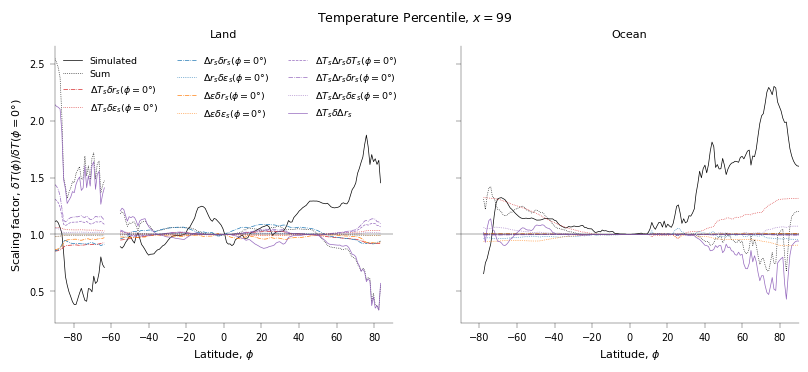

In [540]:
save_non_linear_terms_fig = False
fig, ax = plt.subplots(1,n_surf, figsize=(n_surf*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_exp):
    ax[i].plot(lat, sf_simulated[i, q_plot_ind], color='k', label='Simulated')
    ax[i].plot(lat, 1+(sf_theory['linear'] - sf_theory['simple'])[i, q_plot_ind], color='k', linestyle=':', label='Sum')
    for key in non_linear_keys:
        ax[i].plot(lat, 1+sf_theory_breakdown[key[0]][key[1]][i, q_plot_ind], color=colors_breakdown2[key[1]], 
                   linestyle=linestyles_breakdown[key[0]], 
                   label=labels_breakdown2[key[1]] + ('' if 'anomaly' in key[0] else labels_breakdown1[key[0]]), alpha=1)
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Latitude, $\phi$')
    ax[i].set_title(ds_base[0]['surface'][i].capitalize())
ax[0].legend(ncol=3, loc='upper left', fontsize=6.8)
ax[0].set_ylabel(f'Scaling factor, $\delta T(\phi)/\delta T(\phi={lat_ref:.0f}\degree)$')
ax[0].set_xlim(-90, 90)
fig.suptitle(f'Temperature Percentile, $x={q_plot}$', fontsize=9)

if save_fig or save_non_linear_terms_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_non_linear_terms_{q_plot}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

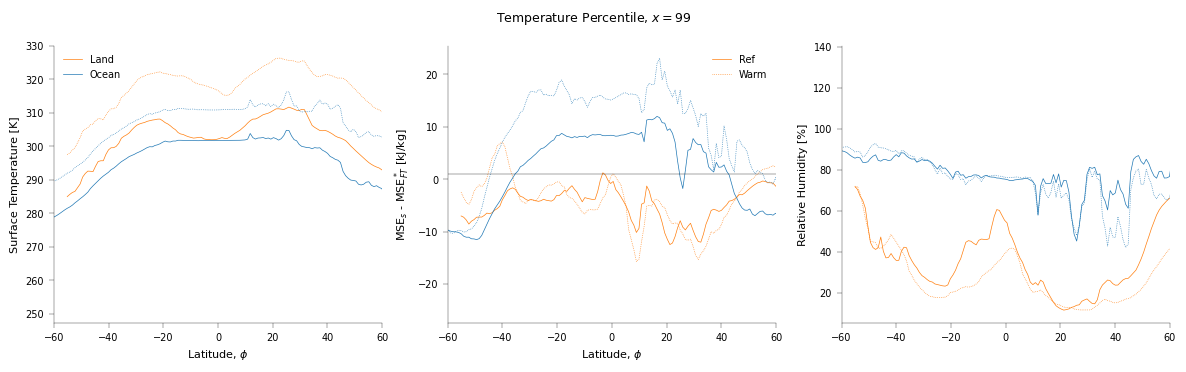

In [576]:
rh = ds['sphum']/sphum_sat(ds['temp'], pressure_surf)
fig, ax = plt.subplots(1,3, figsize=(3*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(n_surf):
    for j in range(n_exp):
        ax[0].plot(lat, ds['temp'][i, q_plot_ind, j], label=ds_base[0]['surface'][i].capitalize() if j==0 else None, color=default_colors[1-i], 
                   linestyle=['-', ':'][j])
        ax[1].plot(lat, ds['mse_lapse'][i, q_plot_ind, j], label=['Ref', 'Warm'][j] if i==0 else None, color=default_colors[1-i], 
                   linestyle=['-', ':'][j])
        ax[2].plot(lat, rh[i, q_plot_ind, j]*100, color=default_colors[1-i], linestyle=['-', ':'][j])
ax[0].set_xlabel('Latitude, $\phi$')
ax[1].set_xlabel('Latitude, $\phi$')
ax[0].set_ylabel('Surface Temperature [K]')
ax[1].set_ylabel('MSE$_s$ - MSE$_{FT}^*$ [kJ/kg]')
ax[2].set_ylabel('Relative Humidity [%]')
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlim(-90, 90)
ax[0].set_xlim(-60, 60)
ax[0].legend()
ax[1].legend()
fig.suptitle(f'Temperature Percentile, $x={q_plot}$', fontsize=9);
# plt.plot(lat, ds['mse_lapse'][1, q_plot_ind, 0])
# plt.plot(ds['mse_lapse'][1, q_plot_ind, 1])